# Time use seminar project
## Setup

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import pandas as pd

from DynamicSpecializationModel_post import DynamicSpecializationModelClass

In [2]:
# solve and simulate baseline model
model = DynamicSpecializationModelClass(par={'prob_birth':0.1})
%time model.solve()
%time model.simulate()

CPU times: user 1.23 s, sys: 31.4 ms, total: 1.26 s
Wall time: 1.53 s
CPU times: user 583 ms, sys: 16.9 ms, total: 600 ms
Wall time: 681 ms


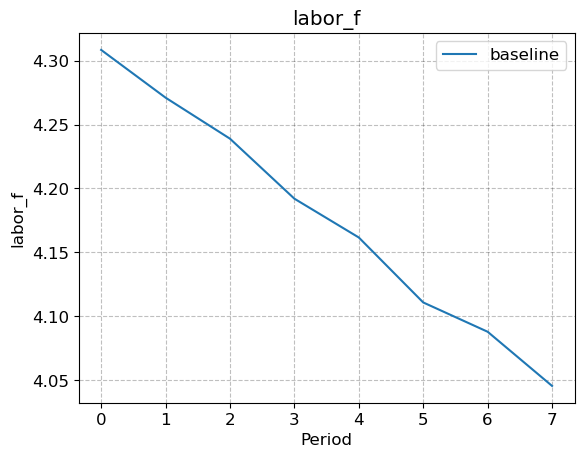

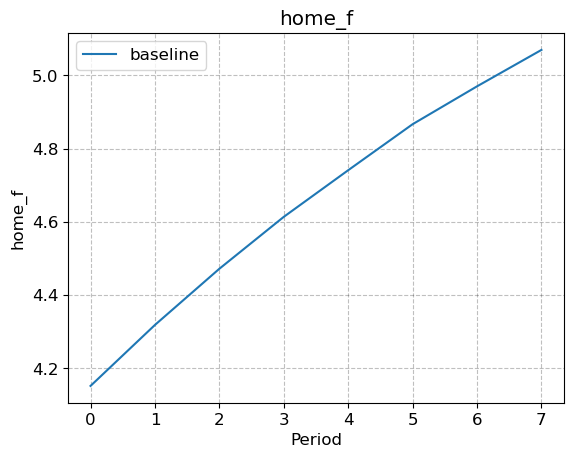

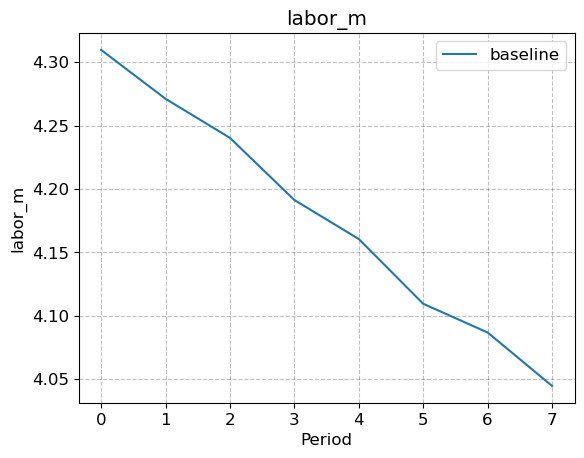

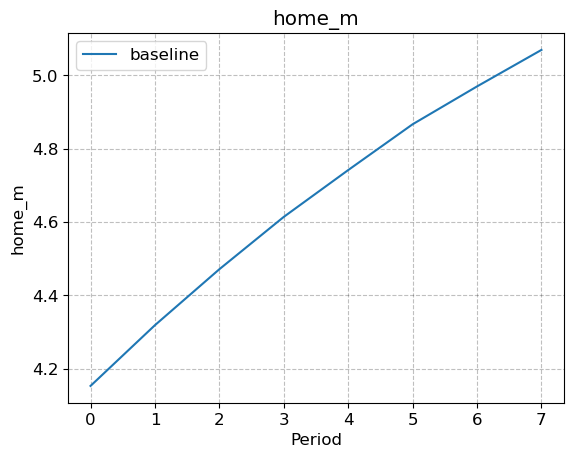

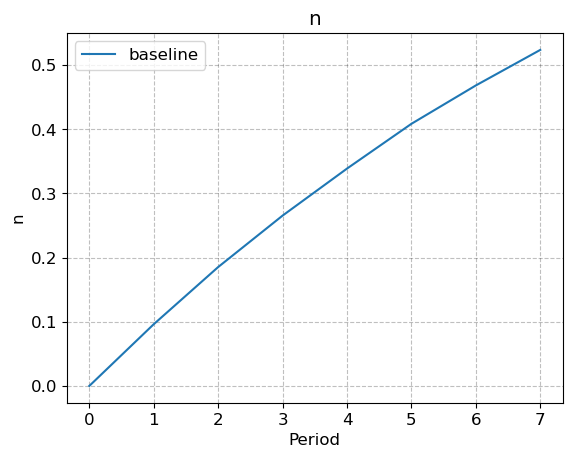

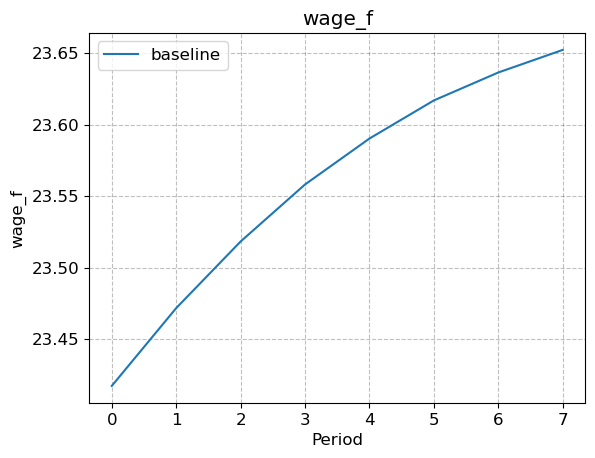

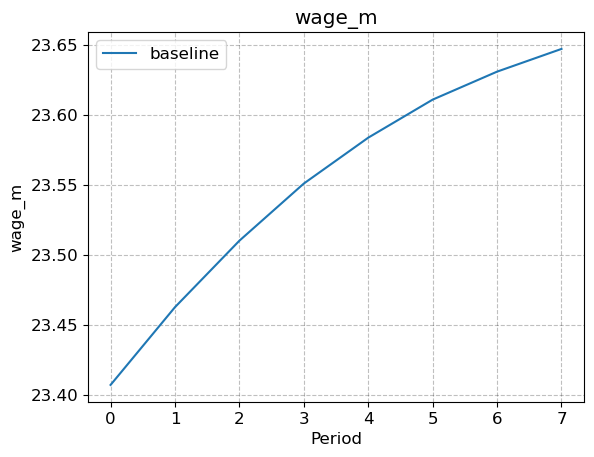

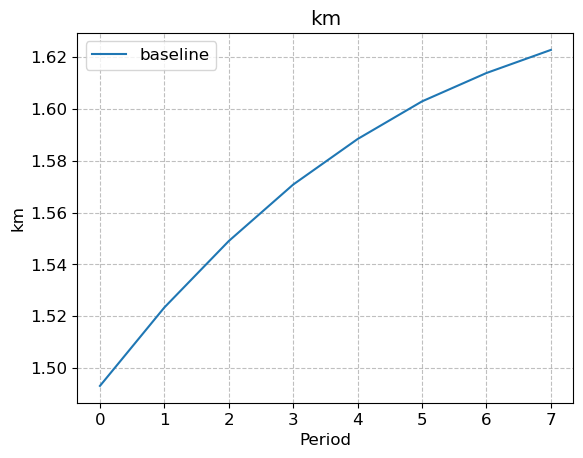

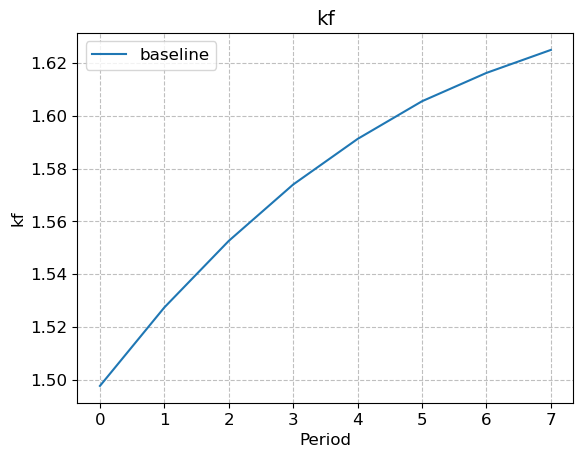

In [3]:
# Solve and simulate the model
model.solve()
model.simulate()

# Plot age profiles and save the figures
for outcome in ('labor_f', 'home_f', 'labor_m', 'home_m', 'n', 'wage_f', 'wage_m', 'km', 'kf'):
    fig, ax = plt.subplots()
    
    # Calculate the mean of the simulated outcome
    outcome_base = np.mean(getattr(model.sim, outcome), axis=0)
    ax.plot(outcome_base, label='baseline')
    
    # Set title and labels
    ax.set(title=outcome, xlabel='Period', ylabel=outcome)
    ax.legend()



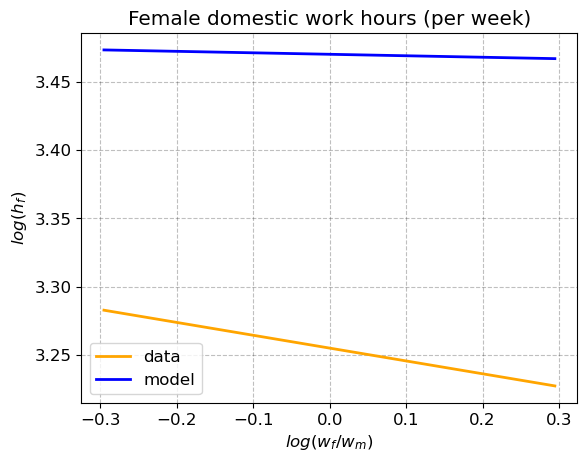

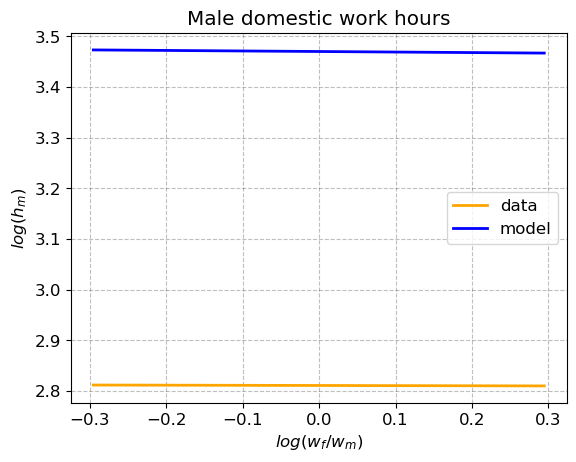

In [4]:
model.plot_female_hours()
model.plot_male_hours()


# Solving various iterations of the model

In [5]:
# solve baseline and extended model
specs = {
    'Base': {'omega_n': -0.131, 'alpha': 0.240, 'alpha_n': -0.120, 'epsilon_f_l': 4.266, 'epsilon_m_l': 3.444, 'epsilon_f_h': 0.721, 'epsilon_m_h': 1.463, 'epsilon_f_l_kids': -1.2, 'epsilon_m_l_kids': 0.013, 'epsilon_f_h_kids': 1.442, 'epsilon_m_h_kids': 0.205, 'nu_f_l': 0.0025, 'nu_f_h': 0.002, 'nu_m_l': 0.002, 'nu_m_h': 0.003, 'nu_f_l_kids': 0.001, 'nu_f_h_kids':-0.0019},
    'Try': {'omega_n': -0.131, 'alpha': 0.240, 'alpha_n': -0.120, 'epsilon_f_l': 4.266, 'epsilon_m_l': 3.444, 'epsilon_f_h': 0.721, 'epsilon_m_h': 1.463, 'epsilon_f_l_kids': -1.2, 'epsilon_m_l_kids': 0.013, 'epsilon_f_h_kids': 1.442, 'epsilon_m_h_kids': 0.205, 'nu_f_l': 0.0025, 'nu_f_h': 0.002, 'nu_m_l': 0.002, 'nu_m_h': 0.003, 'nu_f_l_kids': 0.001, 'nu_f_h_kids':-0.0019}
}


models = dict()
for name,spec in specs.items():
    models[name] = DynamicSpecializationModelClass()
    
    for par_name,val in spec.items():
        setattr(models[name].par,par_name,val)

    models[name].solve()
    models[name].simulate()

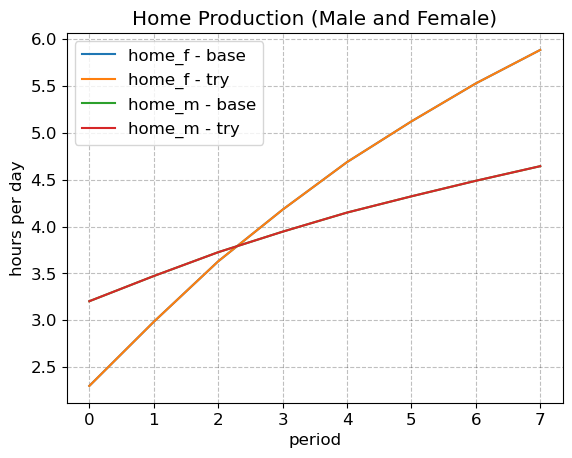

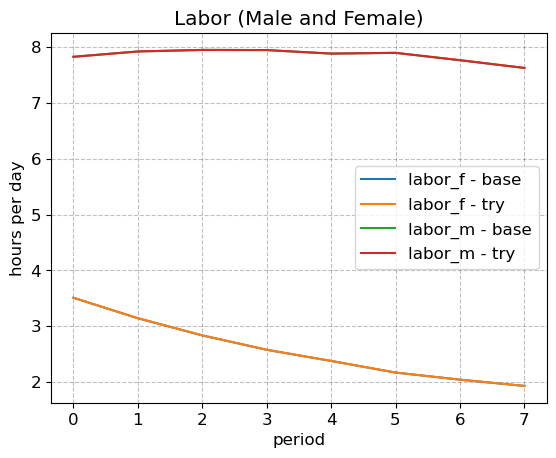

In [6]:
# Group outcomes by context
home_outcomes = ['home_f', 'home_m']
labor_outcomes = ['labor_f', 'labor_m']

# Define a function to plot grouped outcomes
def plot_outcomes(group, title):
    fig, ax = plt.subplots()
    for outcome in group:
        # Extract the base and try outcomes
        outcome_base = np.mean(getattr(models['Base'].sim, outcome), axis=0)
        outcome_try = np.mean(getattr(models['Try'].sim, outcome), axis=0)
        
        # Plot for 'base' and 'try' scenarios
        ax.plot(outcome_base, label=f'{outcome} - base')
        ax.plot(outcome_try, label=f'{outcome} - try')
    
    # Set titles and labels
    ax.set(title=title, xlabel='period', ylabel='hours per day')
    ax.legend()
    plt.show()

# Plot for home production
plot_outcomes(home_outcomes, title='Home Production (Male and Female)')

# Plot for labor
plot_outcomes(labor_outcomes, title='Labor (Male and Female)')

## Calculating some moments from the model

In [7]:
# the model is from now on the extended version
model = models['Try'].copy()
print(model.par)



namespace(T=8, beta=0.98, rho=2.0, nu_f_l=0.0025, nu_f_h=0.002, nu_m_l=0.002, nu_m_h=0.003, nu_f_l_kids=0.001, nu_f_h_kids=-0.0019, nu_m_l_kids=0.0, nu_m_h_kids=0.0, epsilon_f_l=4.266, epsilon_m_l=3.444, epsilon_f_h=0.721, epsilon_m_h=1.463, epsilon_f_l_kids=-1.2, epsilon_m_l_kids=0.013, epsilon_f_h_kids=1.442, epsilon_m_h_kids=0.205, omega=0.5, omega_n=-0.131, power=0.5, alpha=0.24, alpha_n=-0.12, sigma=0.3, sigma_n=0.0, wage_const_f=3.0, wage_humcap_f=0.1, wage_const_m=3.0, wage_humcap_m=0.1, X=0.0, delta=0.1, prob_birth=0.1, num_n=2, num_K=10, max_K=15.0, simT=8, simN=10000, grid_K=array([ 0.        ,  1.3379026 ,  2.72503652,  4.16852182,  5.67763341,
        7.26493398,  8.9483755 , 10.75571022, 12.73574142, 15.        ]), grid_n=array([0, 1]))


In [8]:
def calculate_event_mean_new(model, outcome_str, min_time=-5, max_time=5):
    """
    Calculate average outcome across time since birth, in levels.

    Parameters:
    model (object): The model object containing parameters and simulation results.
    outcome_str (str): The name of the outcome variable to analyze.
    min_time (int): Minimum time (relative to birth) to include in the event window.
    max_time (int): Maximum time (relative to birth) to include in the event window.

    Returns:
    tuple: (event_grid, event_outcome) - time grid and average outcomes at each time.
    """
    par = model.par
    sim = model.sim

    # Time periods
    periods = np.tile([t for t in range(par.simT)], (par.simN, 1))
    time_of_birth = np.max(periods * sim.birth, axis=1)

    # Identify individuals who have a birth event
    has_birth = time_of_birth > 0
    time_of_birth[~has_birth] = -1000  # For those who never have a child
    time_of_birth = np.transpose(np.tile(time_of_birth, (par.simT, 1)))

    # Time since birth
    time_since_birth = periods - time_of_birth

    # Get the outcome variable (e.g., domestic or market work)
    outcome = getattr(sim, outcome_str)

    # Calculate event-study means
    event_grid = np.arange(min_time, max_time + 1)
    event_outcome = np.full(event_grid.size, np.nan)
    for t, time in enumerate(event_grid):
        event_outcome[t] = np.mean(outcome[time_since_birth == time])

    return event_grid, event_outcome


In [9]:
def calculate_event_mean(model,outcome_str,min_time=-5,max_time=5,relative=-1,pct=True):
    ''' calculate average outcome across time since birth '''

    par = model.par
    sim = model.sim

    # time since birth
    periods = np.tile([t for t in range(par.simT)],(par.simN,1))
    time_of_birth = np.max(periods * sim.birth, axis=1)

    I = time_of_birth>0
    time_of_birth[~I] = -1000 # never has a child
    time_of_birth = np.transpose(np.tile(time_of_birth , (par.simT,1)))

    time_since_birth = periods - time_of_birth

    # event-study mean
    outcome = getattr(sim,outcome_str)
    event_grid = np.arange(min_time,max_time+1)

    event_outcome = np.nan + np.zeros(event_grid.size)
    for t,time in enumerate(event_grid):
        event_outcome[t] = np.mean(outcome[time_since_birth==time])

    # relative to period before birth
    if relative is not None:
        event_outcome_rel = event_outcome - event_outcome[event_grid==relative]
        if pct:
            event_outcome = event_outcome_rel/event_outcome[event_grid==relative]
        else:
            event_outcome = event_outcome_rel

    # return the indicators of distance to event along with the average outcome for each time periode            
    return event_grid,event_outcome

In [10]:
def calculate_event_levels(model, outcome_str, pre_range=(-5, -1), post_range=(1, 5)):
    """
    Calculate pre-birth average, the jump at childbirth, and post-birth average for an outcome.

    Parameters:
    model (object): The model object containing parameters and simulation results.
    outcome_str (str): The name of the outcome variable to analyze.
    pre_range (tuple): The range of time periods to calculate the pre-birth average (inclusive).
    post_range (tuple): The range of time periods to calculate the post-birth average (inclusive).

    Returns:
    tuple: (pre_avg, jump, post_avg)
    """
    par = model.par
    sim = model.sim

    # Time periods
    periods = np.tile([t for t in range(par.simT)], (par.simN, 1))
    time_of_birth = np.max(periods * sim.birth, axis=1)

    # Identify individuals who have a birth event
    I = time_of_birth > 0
    time_of_birth[~I] = -1000  # Never has a child
    time_of_birth = np.transpose(np.tile(time_of_birth, (par.simT, 1)))

    # Time since birth
    time_since_birth = periods - time_of_birth

    # Get the outcome variable
    outcome = getattr(sim, outcome_str)

    # Pre-birth average
    pre_mask = (time_since_birth >= pre_range[0]) & (time_since_birth <= pre_range[1])
    pre_avg = np.mean(outcome[pre_mask])

    # Jump at childbirth (period 0)
    jump_mask = (time_since_birth == 0)
    jump = np.mean(outcome[jump_mask]) - pre_avg

    # Post-birth average
    post_mask = (time_since_birth >= post_range[0]) & (time_since_birth <= post_range[1])
    post_avg = np.mean(outcome[post_mask])

    return pre_avg, jump, post_avg


In [11]:
def calculate_time_mean(model, outcome_str):
    ''' Calculate the average outcome across time periods '''

    sim = model.sim
    par = model.par

    # Extract the outcome variable over time
    outcome = getattr(sim, outcome_str)

    # Calculate the average outcome for each time period
    time_grid = np.arange(par.simT)
    time_outcome = np.mean(outcome, axis=0)

    # Return the time grid along with the average outcome for each time period
    return time_grid, time_outcome


In [12]:
def calculate_overall_mean(model, outcome_str):
    ''' Calculate the overall average of the outcome across all time periods '''

    sim = model.sim

    # Extract the outcome variable over time
    outcome = getattr(sim, outcome_str)

    # Calculate the overall average outcome across all time periods and simulations
    overall_mean = np.mean(outcome)

    # Return the overall mean
    return overall_mean

# Calculate the average labor supply
avg_labor_f = calculate_overall_mean(model, 'labor_f')
avg_labor_m = calculate_overall_mean(model, 'labor_m')
print(f'Average female labor supply is {avg_labor_f:.2f}')
print(f'Average male labor supply is {avg_labor_m:.2f}')

# calculate average wages
avg_wage_f = calculate_overall_mean(model, 'wage_f')
avg_wage_m = calculate_overall_mean(model, 'wage_m')
print(f'Average female wage is {avg_wage_f:.2f}')
print(f'Average male wage is {avg_wage_m:.2f}')


Average female labor supply is 2.57
Average male labor supply is 7.85
Average female wage is 23.19
Average male wage is 24.63


In [13]:
# test the function with hours in home production
calculate_time_mean(model, 'home_f')

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 array([2.2980454 , 2.98234264, 3.62793874, 4.17963594, 4.68763984,
        5.12247788, 5.52801466, 5.88566873]))

## Structural estimation with SMM

In [14]:
# Define the new structure for moms_data with moments for -5 to +5 years
years = list(range(-5, 6))
variables = ['h_f', 'h_m', 'l_f', 'l_m']  # Domestic (h) and market (l) work for females (f) and males (m)
moments = [f"{year}_{var}" for year in years for var in variables]

# Initialize moms_data
moms_data = pd.DataFrame({
    'moment': moments,
    'value': [None] * len(moments)  # Placeholder for values
})

# Load the Stata moments
stata_moments = pd.read_csv("Yearly_Moments_Data.csv")

# Populate moms_data with moments from the CSV
for year in years:
    # Extract data for the current year
    row = stata_moments.loc[stata_moments['years_baby'] == year]

    if not row.empty:  # Ensure the year exists in the CSV
        moms_data.loc[moms_data['moment'] == f"{year}_h_f", 'value'] = row['housework_fem_daily'].values[0]
        moms_data.loc[moms_data['moment'] == f"{year}_h_m", 'value'] = row['housework_mal_daily'].values[0]
        moms_data.loc[moms_data['moment'] == f"{year}_l_f", 'value'] = row['marketwork_fem_daily'].values[0]
        moms_data.loc[moms_data['moment'] == f"{year}_l_m", 'value'] = row['marketwork_mal_daily'].values[0]

# Print the updated moms_data for verification
print(moms_data)


    moment      value
0   -5_h_f   2.871533
1   -5_h_m   2.045851
2   -5_l_f   5.399024
3   -5_l_m   6.958318
4   -4_h_f   2.693561
5   -4_h_m   2.115406
6   -4_l_f   5.477206
7   -4_l_m    6.86952
8   -3_h_f   3.144586
9   -3_h_m   2.113947
10  -3_l_f   5.432715
11  -3_l_m   6.983472
12  -2_h_f   3.464865
13  -2_h_m   2.357665
14  -2_l_f   5.098312
15  -2_l_m   6.738259
16  -1_h_f     4.1541
17  -1_h_m   2.653807
18  -1_l_f   4.301057
19  -1_l_m   6.867889
20   0_h_f  10.340913
21   0_h_m   4.149493
22   0_l_f   1.421732
23   0_l_m   6.793361
24   1_h_f   9.706228
25   1_h_m   4.537802
26   1_l_f   2.361231
27   1_l_m   6.840475
28   2_h_f   9.838212
29   2_h_m   4.475718
30   2_l_f   2.230471
31   2_l_m   6.876624
32   3_h_f   9.844695
33   3_h_m    4.57048
34   3_l_f   2.492235
35   3_l_m   6.971929
36   4_h_f   9.322656
37   4_h_m   4.465989
38   4_l_f   2.597092
39   4_l_m   6.899998
40   5_h_f   9.126821
41   5_h_m   4.287644
42   5_l_f    2.56936
43   5_l_m   7.034811


In [15]:
# Add regression moments to the moms_data DataFrame
regression_moments = pd.DataFrame({
    'moment': [
        'constant_share', 'slope_share'
    ],
    'value': [0.4, -0.1]  # Replace with actual regression values
})

# Append regression moments to moms_data
moms_data = pd.concat([regression_moments, moms_data], ignore_index=True)

# Print the updated moms_data for verification
#print(moms_data)


In [16]:
# To access the data values for optimization:
moms_data_values = moms_data['value'].to_numpy()

# Example: print labeled moments
#print(moms_data)

In [17]:
def calc_moments(model):
    """
    Calculate all model moments based on simulation results, including moments for each year before and after childbirth.
    """
    # Helper to calculate yearly moments using `calculate_event_mean_new`
    def calculate_yearly_moments(model, variable, years=(-5, 5)):
        """
        Calculate moments for each year in the given range for a specific variable.
        """
        min_time, max_time = years
        event_grid, event_outcome = calculate_event_mean_new(model, variable, min_time, max_time)
        return event_outcome

    # Calculate moments for each year (-5 to +5) for home and labor work
    home_f_moments = calculate_yearly_moments(model, 'home_f')
    home_m_moments = calculate_yearly_moments(model, 'home_m')
    labor_f_moments = calculate_yearly_moments(model, 'labor_f')
    labor_m_moments = calculate_yearly_moments(model, 'labor_m')

    # Female/male share regression coefficients
    constant_share, slope_share = model.regress()

    # Male home production regression coefficients
    #constant_m, slope_m = model.regress_male()

    # Female home production regression coefficients
    #constant_f, slope_f = model.regress_female()

    # Combine all moments into a numpy array
    return np.array([
        constant_share, slope_share,
        *home_f_moments,  # Moments for home work (female)
        *home_m_moments,  # Moments for home work (male)
        *labor_f_moments, # Moments for market work (female)
        *labor_m_moments  # Moments for market work (male)
    ])

# Updated labels for all moments
moms_labels = [
    'constant_share', 'slope_share',
]

# Standardize labels to match data moments
years_range = range(-5, 6)
variables = ['h_f', 'h_m', 'l_f', 'l_m']
regression_labels = ['constant_share', 'slope_share']
event_labels = [f"{year}_{var}" for year in years_range for var in variables]
moms_labels = regression_labels + event_labels
print(moms_labels)


# Calculate model moments
moms_model = calc_moments(model)



# Combine model moments and data moments
results = pd.DataFrame({
    'moment': moms_labels,
    'model': moms_model
})

# Ensure the `moment` labels in `moms_data` are consistent
data_moments_df = pd.DataFrame({'moment': moms_data['moment'], 'data': moms_data['value']})

# Merge the datasets
results = results.merge(data_moments_df, on='moment', how='left')

# Print the final merged DataFrame
print(results)



['constant_share', 'slope_share', '-5_h_f', '-5_h_m', '-5_l_f', '-5_l_m', '-4_h_f', '-4_h_m', '-4_l_f', '-4_l_m', '-3_h_f', '-3_h_m', '-3_l_f', '-3_l_m', '-2_h_f', '-2_h_m', '-2_l_f', '-2_l_m', '-1_h_f', '-1_h_m', '-1_l_f', '-1_l_m', '0_h_f', '0_h_m', '0_l_f', '0_l_m', '1_h_f', '1_h_m', '1_l_f', '1_l_m', '2_h_f', '2_h_m', '2_l_f', '2_l_m', '3_h_f', '3_h_m', '3_l_f', '3_l_m', '4_h_f', '4_h_m', '4_l_f', '4_l_m', '5_h_f', '5_h_m', '5_l_f', '5_l_m']
            moment     model       data
0   constant_share -0.144826        0.4
1      slope_share -0.585896       -0.1
2           -5_h_f  2.298152   2.871533
3           -5_h_m  2.298463   2.045851
4           -5_l_f  2.299081   5.399024
5           -5_l_m  2.299701   6.958318
6           -4_h_f  2.300593   2.693561
7           -4_h_m  9.191677   2.115406
8           -4_l_f  9.185553   5.477206
9           -4_l_m  9.179595    6.86952
10          -3_h_f  9.172741   3.144586
11          -3_h_m  9.166356   2.113947
12          -3_l_f  9.158083  

In [18]:
def obj(theta, theta_names, model, moms_data, include_regression=False, do_print=False):
    """
    Objective function with weighted moments.
    
    Parameters:
    - theta: Array of parameters to estimate.
    - theta_names: List of parameter names.
    - model: Model object.
    - moms_data: Data moments DataFrame.
    - include_regression: Boolean, whether to include regression moments in the objective function.
    - do_print: If True, print progress and squared sum.
    
    Returns:
    - Weighted sum of squared differences between model and data moments.
    """
    # Step 1: Update parameters
    for i, name in enumerate(theta_names):
        setattr(model.par, name, theta[i])
    
    # Step 2: Solve and simulate the model
    model.solve()
    model.simulate()
    
    # Step 3: Calculate model moments
    moms_model = calc_moments(model)
    
    # Step 4: Extract data moments and labels
    moms_labels = moms_data['moment'].to_list()
    moms_data_values = moms_data['value'].to_numpy()
    
    # Step 5: Assign weights
    weights = np.ones(len(moms_labels))  # Initialize weights as 1
    
    # Assign weights to regression moments if included
    num_regression_moments = 2  # Adjust as needed
    if include_regression:
        regression_weights = np.ones(num_regression_moments) * 0.5 / num_regression_moments
        weights[:num_regression_moments] = regression_weights
    else:
        weights[:num_regression_moments] = 0  # Set weight of regression moments to zero
    
    # Assign weights to event study moments
    event_study_weights = np.zeros(len(moms_labels) - num_regression_moments)
    for i, label in enumerate(moms_labels[num_regression_moments:]):
        # Extract the year from the label (e.g., '-5_h_f')
        year = int(label.split('_')[0])
        distance_weight = 1.0 / (1 + abs(year))  # Weight decreases with distance from 0
        event_study_weights[i] = 0.5 * distance_weight / np.sum(1.0 / (1 + abs(np.arange(-5, 6))))  # Normalize
    
    # Combine weights
    weights[num_regression_moments:] = event_study_weights
    
    # Step 6: Calculate weighted squared differences
    diff = moms_model - moms_data_values
    sqsum = np.sum(weights * diff**2)
    
    # Step 7: Print progress if requested
    if do_print:
        for i, name in enumerate(theta_names):
            print(f"'{name}': {theta[i]:2.3f} ", end="")
        print(f"-> sqsum={sqsum:2.8f}", end="\r")
    
    # Step 8: Return weighted squared sum
    return sqsum


In [19]:
def obj_old(theta, theta_names, model, moms_data, do_print=False):
    """
    Objective function with weighted moments.
    
    Parameters:
    - theta: Array of parameters to estimate.
    - theta_names: List of parameter names.
    - model: Model object.
    - moms_data: Data moments DataFrame.
    - do_print: If True, print progress and squared sum.
    
    Returns:
    - Weighted sum of squared differences between model and data moments.
    """
    # Step 1: Update parameters
    for i, name in enumerate(theta_names):
        setattr(model.par, name, theta[i])
    
    # Step 2: Solve and simulate the model
    model.solve()
    model.simulate()
    
    # Step 3: Calculate model moments
    moms_model = calc_moments(model)
    
    # Step 4: Extract data moments and labels
    moms_labels = moms_data['moment'].to_list()
    moms_data_values = moms_data['value'].to_numpy()
    
    # Step 5: Assign weights
    weights = np.ones(len(moms_labels))  # Initialize weights as 1
    
    # Assign half weight to regression moments
    num_regression_moments = 2
    regression_weights = np.ones(num_regression_moments) * 0.5 / num_regression_moments
    
    # Assign weights to event study moments
    event_study_weights = np.zeros(len(moms_labels) - num_regression_moments)
    for i, label in enumerate(moms_labels[num_regression_moments:]):
        # Extract the year from the label (e.g., '-5_h_f')
        year = int(label.split('_')[0])
        distance_weight = 1.0 / (1 + abs(year))  # Weight decreases with distance from 0
        event_study_weights[i] = 0.5 * distance_weight / np.sum(1.0 / (1 + abs(np.arange(-5, 6))))  # Normalize
    
    # Combine weights
    weights[:num_regression_moments] = regression_weights
    weights[num_regression_moments:] = event_study_weights
    
    # Step 6: Calculate weighted squared differences
    diff = moms_model - moms_data_values
    sqsum = np.sum(weights * diff**2)
    
    # Step 7: Print progress if requested
    if do_print:
        for i, name in enumerate(theta_names):
            print(f"{'name'}: {theta[i]:2.3f} ", end="")
        print(f"-> sqsum={sqsum:2.8f}", end="\r")
    
    # Step 8: Return weighted squared sum
    return sqsum


In [20]:
# Full list of parameter names
theta_names = (
    'omega_n',           # Omega for no kids
    'alpha',             # Alpha parameter
    'alpha_n',           # Alpha for no kids
    'epsilon_f_l',       # Female elasticity for labor (low)
    'epsilon_m_l',       # Male elasticity for labor (low)
    'epsilon_f_h',       # Female elasticity for home production (high)
    'epsilon_m_h',       # Male elasticity for home production (high)
    'epsilon_f_l_kids',  # Female elasticity change for labor with kids
    'epsilon_m_l_kids',  # Male elasticity change for labor with kids
    'epsilon_f_h_kids',  # Female elasticity change for home production with kids
    'epsilon_m_h_kids',  # Male elasticity change for home production with kids
    'nu_f_l',            # Female disutility of labor (low)
    'nu_f_h',            # Female disutility of labor (high)
    'nu_m_l',            # Male disutility of labor (low)
    'nu_m_h',            # Male disutility of labor (high)
    'nu_f_l_kids',       # Female disutility of labor with kids (low)
    'nu_f_h_kids'        # Female disutility of labor with kids (high)
)

# Full list of corresponding initial parameter values
theta_init = np.array([
    -0.131,   # omega_n
     0.240,   # alpha
    -0.120,   # alpha_n
     4.266,   # epsilon_f_l
     3.444,   # epsilon_m_l
     0.721,   # epsilon_f_h
     1.463,   # epsilon_m_h
    -1.200,   # epsilon_f_l_kids
     0.013,   # epsilon_m_l_kids
     1.442,   # epsilon_f_h_kids
     0.205,   # epsilon_m_h_kids
     0.0025,  # nu_f_l
     0.0020,  # nu_f_h
     0.0020,  # nu_m_l
     0.0030,  # nu_m_h
     0.0010,  # nu_f_l_kids
    -0.0019   # nu_f_h_kids
])


# Print lengths to ensure consistency
print("Length of theta_init:", len(theta_init))
print("Length of theta_names:", len(theta_names))

# Evaluate the objective function with the updated initial values
obj_init = obj(theta_init, theta_names, model, moms_data, include_regression=False, do_print=True)




Length of theta_init: 17
Length of theta_names: 17


In [21]:
# estimate using a numerical solver
obj_func = lambda theta: obj(theta,theta_names,model,moms_data,include_regression=False,do_print=True)

def smm_calc(do_calcs):
    if do_calcs == True:
        est = minimize(obj_func,theta_init,method='nelder-mead')
    else:
        est = f'not today'
    return est

smm_calc(False)

'not today'

1st Octorber results:
alpha:0.957 alpha_n:0.027 sigma:0.109 omega_n:-0.094 epsilon_f:1.808 epsilon_m:1.711 wage_humcap_f:0.094 wage_humcap_m:0.075 nu:0.008 -> sqsum=0.06351727

11 October results: alpha:0.966 alpha_n:0.033 sigma:0.070 omega_n:-0.071 epsilon_f:1.808 epsilon_m:1.673 wage_humcap_f:0.098 wage_humcap_m:0.151 nu:0.007 -> sqsum=0.03168675

26 October results: alpha:0.797 alpha_n:0.030 sigma:0.139 omega_n:-0.094 epsilon_f:1.822 epsilon_m:1.878 wage_humcap_f:0.098 wage_humcap_m:0.072 nu:0.002 wage_const_f:0.000 wage_const_m:0.000 -> sqsum=1.0468150631


Nov 7 results: alpha:0.988 alpha_n:0.011 sigma:0.112 omega_n:-0.063 epsilon_f:2.391 epsilon_m:2.175 wage_humcap_f:0.100 wage_humcap_m:0.098 nu:0.004 wage_const_f:0.000 wage_const_m:0.000 -> sqsum=0.624178677

Nov 8 alpha:0.860 alpha_n:0.048 sigma:0.313 omega_n:-0.302 epsilon_f:2.208 epsilon_m:2.046 wage_humcap_f:0.231 wage_humcap_m:0.211 nu:0.001 wage_const_f:3.014 wage_const_m:3.006 epsilon_f_kids:-0.193 epsilon_m_kids:0.021 -> sqsum=1.4568378426


Nov 16: Parameters: {'alpha': 0.8641506210467227, 'alpha_n': 0.057671354877293676, 'sigma': 0.32175314646359876, 'omega_n': -0.16186198409865757, 'epsilon_f': 2.082715457262152, 'epsilon_m': 1.9622930263541662, 'wage_humcap_f': 0.2586801058672381, 'wage_humcap_m': 0.24505881724502848, 'nu': 0.0008659026225391137, 'wage_const_f': 2.979080404315563, 'wage_const_m': 2.9361670958853647, 'epsilon_f_kids': -0.2581663148363688, 'epsilon_m_kids': 0.02193040384114739}
Squared Sum: 12.68996782

Nov 17: alpha: 0.277 alpha_n: 0.050 sigma: 0.218 omega_n: -0.237 epsilon_f: 0.939 epsilon_m: 0.950 wage_humcap_f: 0.070 wage_humcap_m: 0.109 nu: 0.002 wage_const_f: 0.001 wage_const_m: -0.001 epsilon_f_kids: -0.486 epsilon_m_kids: 0.027 -> sqsum=24.563651221


Nov 20 looking good: 'omega_n': -0.287 'alpha': 0.744 'alpha_n': -0.094 'epsilon_f_l': 2.722 'epsilon_m_l': 1.927 'epsilon_f_h': 0.508 'epsilon_m_h': 1.017 'epsilon_f_l_kids': -0.807 'epsilon_m_l_kids': 0.000 'epsilon_f_h_kids': 0.418 'epsilon_m_h_kids': 0.107 'nu_f_l': 0.003 'nu_f_h': 0.001 'nu_m_l': 0.002 'nu_m_h': 0.002


## Inspecting Model fit

In [22]:
# make sure we're working with the right model again
model = models['Try'].copy()
model.solve()
model.simulate()

namespace(T=8, beta=0.98, rho=2.0, nu_f_l=0.0025, nu_f_h=0.002, nu_m_l=0.002, nu_m_h=0.003, nu_f_l_kids=0.001, nu_f_h_kids=-0.0019, nu_m_l_kids=0.0, nu_m_h_kids=0.0, epsilon_f_l=4.266, epsilon_m_l=3.444, epsilon_f_h=0.721, epsilon_m_h=1.463, epsilon_f_l_kids=-1.2, epsilon_m_l_kids=0.013, epsilon_f_h_kids=1.442, epsilon_m_h_kids=0.205, omega=0.5, omega_n=-0.131, power=0.5, alpha=0.24, alpha_n=-0.12, sigma=0.3, sigma_n=0.0, wage_const_f=3.0, wage_humcap_f=0.1, wage_const_m=3.0, wage_humcap_m=0.1, X=0.0, delta=0.1, prob_birth=0.1, num_n=2, num_K=10, max_K=15.0, simT=8, simN=10000, grid_K=array([ 0.        ,  1.3379026 ,  2.72503652,  4.16852182,  5.67763341,
        7.26493398,  8.9483755 , 10.75571022, 12.73574142, 15.        ]), grid_n=array([0, 1]))


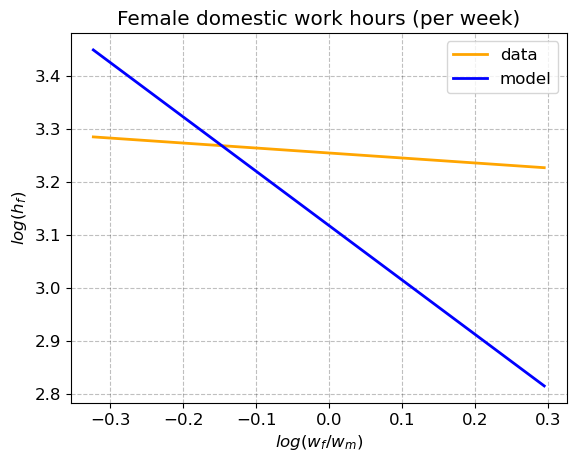

In [23]:
print(model.par)
model.plot_female_hours()

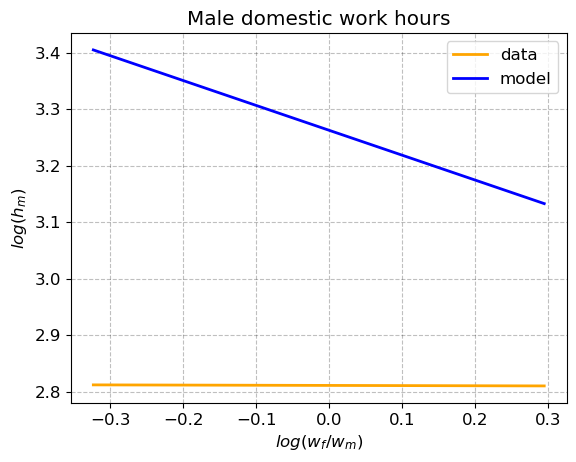

In [24]:
model.plot_male_hours()

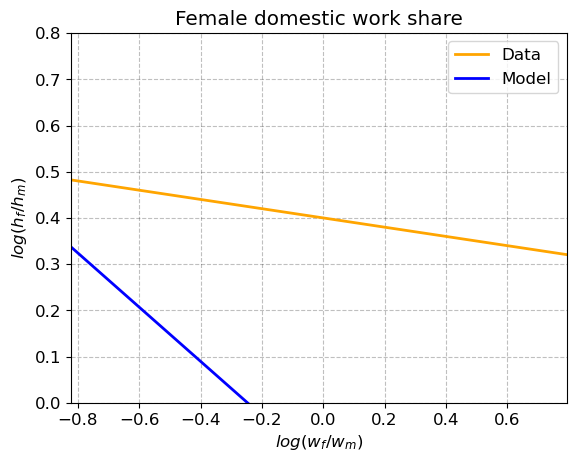

In [25]:
model.plot(True)

In [26]:
def plot_event_study_with_data(model, data_moments, variable, years_range=range(-5, 6)):
    """
    Plots the event study results for a single variable along with data moments.

    Parameters:
    - model: The simulation model providing predicted moments.
    - data_moments: A pandas DataFrame containing the data moments for each year.
    - variable: The specific variable to plot (e.g., 'labor_m', 'labor_f', 'home_m', 'home_f').
    - years_range: The range of years to include in the plot (default: -5 to 5).

    Returns:
    - fig: The matplotlib figure object (for saving).
    """
    # Calculate model-predicted moments
    event_grid, model_moments = calculate_event_mean_new(model, variable, min_time=years_range[0], max_time=years_range[-1])

    # Adjust moment_labels to match data_moments format
    suffix_mapping = {
        'labor_m': 'l_m',
        'labor_f': 'l_f',
        'home_m': 'h_m',
        'home_f': 'h_f'
    }
    suffix = suffix_mapping[variable]
    moment_labels = [f"{year}_{suffix}" for year in years_range]

    # Extract corresponding data moments
    data_values = (
        data_moments.set_index('moment')  # Set 'moment' as index for easier lookup
        .reindex(moment_labels)['value']  # Match the labels and extract values
        .fillna(np.nan)  # Handle missing values
        .values
    )

    # Debug: Check data moments
    print(f"Variable: {variable}")
    print(f"Expected Moment Labels: {moment_labels}")
    print(f"Data Values: {data_values}")

    # Ensure lengths match
    if len(event_grid) != len(data_values):
        print(f"Warning: Mismatch in lengths for {variable}. Check data.")
        return None

    # Create plot
    fig, ax = plt.subplots(figsize=(8, 5))
    
    # Plot model moments
    ax.plot(event_grid, model_moments, marker='o', label='Model', color='blue', linestyle='-', linewidth=2)
    
    # Plot data moments
    ax.plot(event_grid, data_values, color='orange', linestyle='-', linewidth=1.5, alpha=0.8, label='Data', marker='o')

    # Add labels and formatting
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax.axvline(x=0, color='red', linestyle='dashed', linewidth=1)
    ax.set_title(f"Event Study: {variable.replace('_', ' ').capitalize()}")
    ax.set_xlabel("Years Since Birth")
    ax.set_ylabel(f"{variable} (hours per day)")
    ax.legend()
    ax.grid(alpha=0.3)
    
    return fig


In [27]:
import os

# Define the output directory
output_dir = "event_study_moments"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Variables to plot
variables = ['labor_m', 'labor_f', 'home_m', 'home_f']

# Generate and save plots
for variable in variables:
    fig = plot_event_study_with_data(model, moms_data, variable, years_range=range(-5, 6))
    if fig is not None:
        filename = f"event_study_{variable}.png"
        fig.savefig(os.path.join(output_dir, filename), format="png", dpi=300)
        print(f"Figure saved to {os.path.join(output_dir, filename)}")
        plt.close(fig)  # Close the figure after saving to free memory
    else:
        print(f"No figure generated for {variable}.")


Variable: labor_m
Expected Moment Labels: ['-5_l_m', '-4_l_m', '-3_l_m', '-2_l_m', '-1_l_m', '0_l_m', '1_l_m', '2_l_m', '3_l_m', '4_l_m', '5_l_m']
Data Values: [6.9583178 6.8695197 6.9834719 6.7382593 6.8678894 6.7933612 6.8404746
 6.8766241 6.9719291 6.8999977 7.0348115]
Figure saved to event_study_moments/event_study_labor_m.png
Variable: labor_f
Expected Moment Labels: ['-5_l_f', '-4_l_f', '-3_l_f', '-2_l_f', '-1_l_f', '0_l_f', '1_l_f', '2_l_f', '3_l_f', '4_l_f', '5_l_f']
Data Values: [5.399024  5.4772062 5.4327154 5.0983124 4.3010569 1.4217316 2.3612313
 2.2304711 2.4922347 2.5970917 2.5693603]
Figure saved to event_study_moments/event_study_labor_f.png
Variable: home_m
Expected Moment Labels: ['-5_h_m', '-4_h_m', '-3_h_m', '-2_h_m', '-1_h_m', '0_h_m', '1_h_m', '2_h_m', '3_h_m', '4_h_m', '5_h_m']
Data Values: [2.045851  2.1154058 2.1139467 2.3576646 2.6538069 4.1494927 4.5378022
 4.4757175 4.5704803 4.4659891 4.2876444]
Figure saved to event_study_moments/event_study_home_m.png
Var

Variable: labor_m
Expected Moment Labels: ['-5_l_m', '-4_l_m', '-3_l_m', '-2_l_m', '-1_l_m', '0_l_m', '1_l_m', '2_l_m', '3_l_m', '4_l_m', '5_l_m']
Data Values: [6.9583178 6.8695197 6.9834719 6.7382593 6.8678894 6.7933612 6.8404746
 6.8766241 6.9719291 6.8999977 7.0348115]
Figure saved to model_fit/event_study_labor_m.png
Variable: labor_f
Expected Moment Labels: ['-5_l_f', '-4_l_f', '-3_l_f', '-2_l_f', '-1_l_f', '0_l_f', '1_l_f', '2_l_f', '3_l_f', '4_l_f', '5_l_f']
Data Values: [5.399024  5.4772062 5.4327154 5.0983124 4.3010569 1.4217316 2.3612313
 2.2304711 2.4922347 2.5970917 2.5693603]
Figure saved to model_fit/event_study_labor_f.png
Variable: home_m
Expected Moment Labels: ['-5_h_m', '-4_h_m', '-3_h_m', '-2_h_m', '-1_h_m', '0_h_m', '1_h_m', '2_h_m', '3_h_m', '4_h_m', '5_h_m']
Data Values: [2.045851  2.1154058 2.1139467 2.3576646 2.6538069 4.1494927 4.5378022
 4.4757175 4.5704803 4.4659891 4.2876444]
Figure saved to model_fit/event_study_home_m.png
Variable: home_f
Expected Moment 

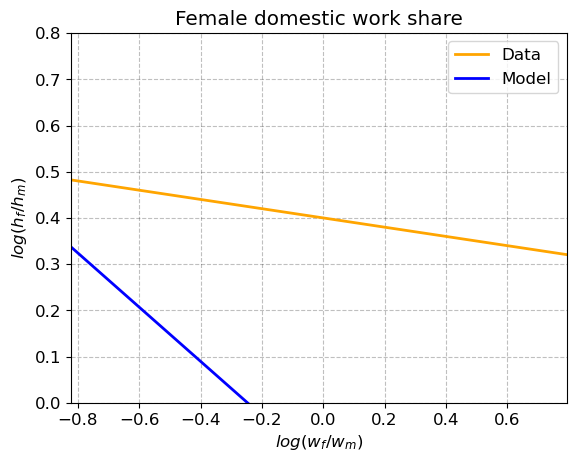

Figure saved to model_fit/regression_model_plot.png
Figure saved to model_fit/regression_female_hours.png
Figure saved to model_fit/regression_male_hours.png


In [28]:
import os
import matplotlib.pyplot as plt

# Define the output directory
output_dir = "model_fit"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Variables to plot for the event study
variables = ['labor_m', 'labor_f', 'home_m', 'home_f']

# Generate and save event study plots
for variable in variables:
    fig = plot_event_study_with_data(model, moms_data, variable, years_range=range(-5, 6))
    if fig is not None:
        filename = f"event_study_{variable}.png"
        fig.savefig(os.path.join(output_dir, filename), format="png", dpi=300)
        print(f"Figure saved to {os.path.join(output_dir, filename)}")
        plt.close(fig)  # Close the figure after saving to free memory
    else:
        print(f"No figure generated for {variable}.")

# Generate and save regression plots
# Save the `model.plot` figure
model.plot(add_regression=True)  # This displays the plot
fig1 = plt.gcf()  # Get the current figure
fig1.savefig(os.path.join(output_dir, "regression_model_plot.png"), format="png", dpi=300)
print(f"Figure saved to {os.path.join(output_dir, 'regression_model_plot.png')}")
plt.close(fig1)

# Save the `model.plot_female_hours` figure
model.plot_female_hours(add_regression=True)  # This displays the plot
fig2 = plt.gcf()  # Get the current figure
fig2.savefig(os.path.join(output_dir, "regression_female_hours.png"), format="png", dpi=300)
print(f"Figure saved to {os.path.join(output_dir, 'regression_female_hours.png')}")
plt.close(fig2)

# Save the `model.plot_male_hours` figure
model.plot_male_hours(add_regression=True)  # This displays the plot
fig3 = plt.gcf()  # Get the current figure
fig3.savefig(os.path.join(output_dir, "regression_male_hours.png"), format="png", dpi=300)
print(f"Figure saved to {os.path.join(output_dir, 'regression_male_hours.png')}")
plt.close(fig3)


## Simulated Behaviour with the calibrated model

In [29]:
import os

# Define the output directory
output_dir = "simulated_behaviour"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Solve and simulate the model
model.solve()
model.simulate()

# Plot age profiles and save the figures
for outcome in ('labor_f', 'home_f', 'labor_m', 'home_m', 'n', 'wage_f', 'wage_m', 'km', 'kf'):
    fig, ax = plt.subplots()
    
    # Calculate the mean of the simulated outcome
    outcome_base = np.mean(getattr(model.sim, outcome), axis=0)
    ax.plot(outcome_base, label='baseline')
    
    # Set title and labels
    ax.set(title=outcome, xlabel='Period', ylabel=outcome)
    ax.legend()
    
    # Save the plot
    filename = f"{outcome}_profile.png"
    fig.savefig(os.path.join(output_dir, filename), format="png", dpi=300)
    print(f"Figure saved to {os.path.join(output_dir, filename)}")
    
    # Close the figure to free up memory
    plt.close(fig)


Figure saved to simulated_behaviour/labor_f_profile.png
Figure saved to simulated_behaviour/home_f_profile.png
Figure saved to simulated_behaviour/labor_m_profile.png
Figure saved to simulated_behaviour/home_m_profile.png
Figure saved to simulated_behaviour/n_profile.png
Figure saved to simulated_behaviour/wage_f_profile.png
Figure saved to simulated_behaviour/wage_m_profile.png
Figure saved to simulated_behaviour/km_profile.png
Figure saved to simulated_behaviour/kf_profile.png


## Counterfactuals

In [40]:
#10% increase in wage_const_f
model_reform_f_const_10pct = model.copy()
model_reform_f_const_10pct.par.wage_const_f = model.par.wage_const_f + 1.0

# increase of 0.01 in child transfers 
model_reform_X = model.copy()
model_reform_X.par.X = model.par.X + 30




In [41]:


# solve constant wage reform
model_reform_f_const_10pct.solve()
model_reform_f_const_10pct.simulate()

# solve X reform
model_reform_X.solve()
model_reform_X.simulate()




In [42]:
import os
import matplotlib.pyplot as plt

# Define the output directory
output_dir = "event_study_reforms"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Variables to plot
variables = ['labor_m', 'labor_f', 'home_m', 'home_f']
years_range = range(-5, 6)

# Function to calculate the event study moments
def calculate_event_study_moments(model, variable, years_range):
    event_grid, moments = calculate_event_mean_new(model, variable, min_time=years_range[0], max_time=years_range[-1])
    return event_grid, moments

# Generate and save plots
for variable in variables:
    fig, ax = plt.subplots(figsize=(8, 5))

    # Baseline moments
    baseline_grid, baseline_moments = calculate_event_study_moments(model, variable, years_range)
    ax.plot(baseline_grid, baseline_moments, label="Baseline", color="blue", linestyle="-", linewidth=2, marker="o")

    # Reform 1: 10% increase in wage_const_f
    reform1_grid, reform1_moments = calculate_event_study_moments(model_reform_f_const_10pct, variable, years_range)
    ax.plot(reform1_grid, reform1_moments, label="10% Increase in Female Wage", color="orange", linestyle="--", linewidth=2, marker="x")

    # Reform 2: Increase of 0.01 in child transfers
    reform2_grid, reform2_moments = calculate_event_study_moments(model_reform_X, variable, years_range)
    ax.plot(reform2_grid, reform2_moments, label="Introduction of Child-related Transfers", color="green", linestyle=":", linewidth=2, marker="s")

    # Formatting
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax.axvline(x=0, color='red', linestyle='dashed', linewidth=1)
    ax.set_title(f"Event Study: {variable.replace('_', ' ').capitalize()}")
    ax.set_xlabel("Years Since Birth")
    ax.set_ylabel(f"{variable} (hours per day)")
    ax.legend(loc='best')
    ax.grid(alpha=0.3)

    # Save the figure
    filename = f"event_study_reform_{variable}.png"
    fig.savefig(os.path.join(output_dir, filename), format="png", dpi=300)
    print(f"Figure saved to {os.path.join(output_dir, filename)}")
    plt.close(fig)  # Close the figure after saving to free memory


Figure saved to event_study_reforms/event_study_reform_labor_m.png
Figure saved to event_study_reforms/event_study_reform_labor_f.png
Figure saved to event_study_reforms/event_study_reform_home_m.png
Figure saved to event_study_reforms/event_study_reform_home_f.png


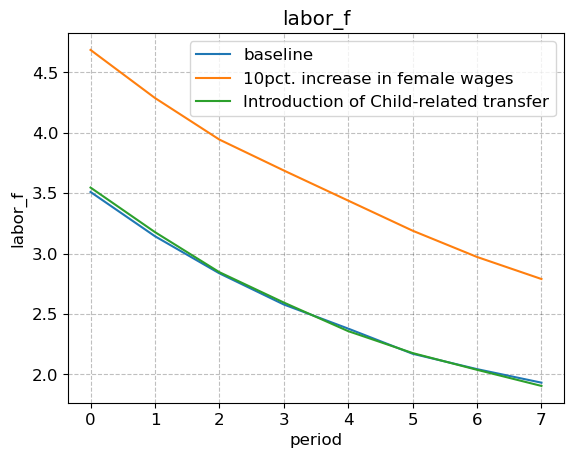

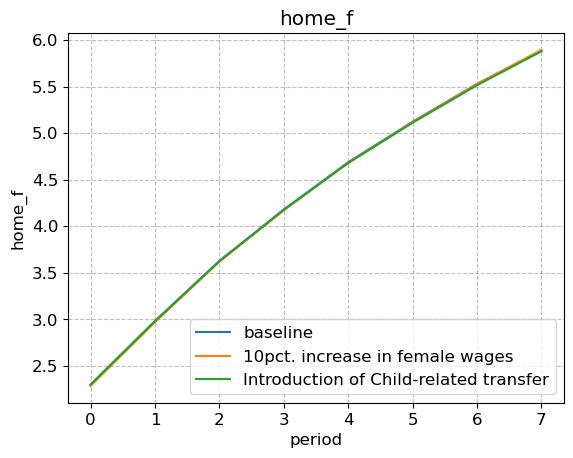

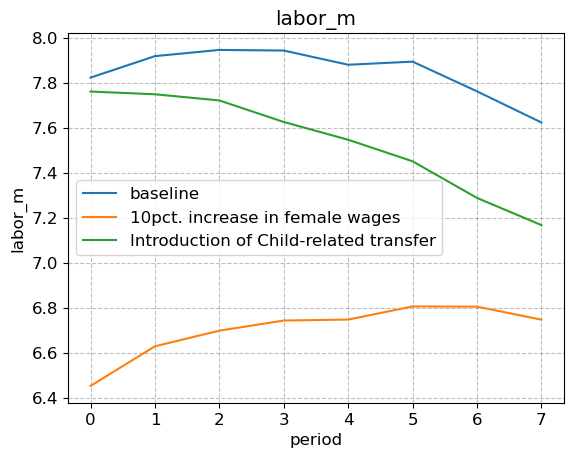

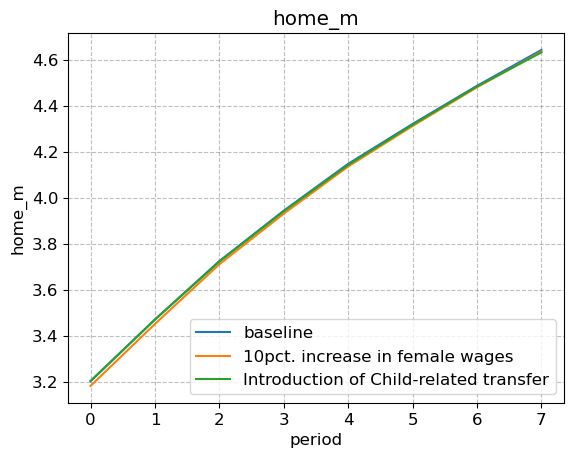

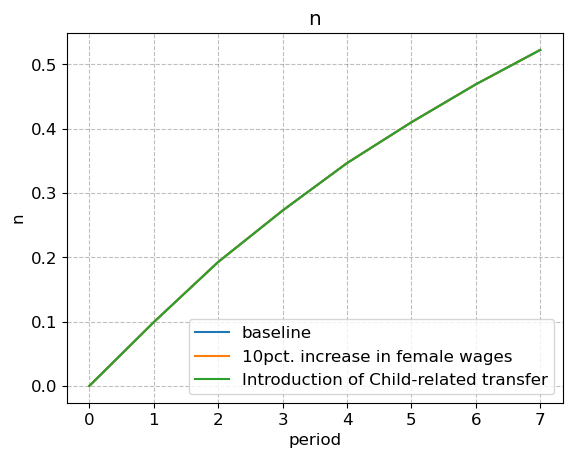

In [33]:
for outcome in ('labor_f','home_f','labor_m','home_m','n'):
    fig, ax = plt.subplots()
    outcome_baseline = np.mean(getattr(model.sim, outcome), axis=0)
    outcome_reform_f = np.mean(getattr(model_reform_f_const_10pct.sim, outcome), axis=0)
    outcome_reform_X = np.mean(getattr(model_reform_X.sim, outcome), axis=0)
    
    
    # Plot the available data
    ax.plot(outcome_baseline, label='baseline')
    ax.plot(outcome_reform_f, label='10pct. increase in female wages')
    ax.plot(outcome_reform_X, label='Introduction of Child-related transfer')


        
    


    ax.set(title=outcome, xlabel='period', ylabel=outcome)
    ax.legend()


## Sensitivity to calibrated parameters

In [34]:
#10% increase in female power
model_matriarchy = model.copy()
model_matriarchy.par.power = model.par.power * 1.1
print(model_matriarchy.par.power)

#10% increase in human capital depreciations
model_humcap = model.copy()
model_humcap.par.delta = model.par.delta * 1.1
print(model_humcap.par.delta)



0.55
0.11000000000000001


In [35]:
# solve and simulate both models
model_humcap.solve()
model_humcap.simulate()


model_matriarchy.solve()
model_humcap.simulate()

In [36]:
import os

# Define the output directory
output_dir = "sensitivity_analysis"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Solve and simulate the sensitivity models
model_matriarchy.solve()
model_matriarchy.simulate()

model_humcap.solve()
model_humcap.simulate()

# Variables to plot
variables = ['labor_m', 'labor_f', 'home_m', 'home_f']

# Generate and save sensitivity analysis plots
for variable in variables:
    fig, ax = plt.subplots(figsize=(8, 5))
    
    # Baseline model
    event_grid, baseline_moments = calculate_event_mean_new(model, variable, min_time=-5, max_time=5)
    ax.plot(event_grid, baseline_moments, label='Baseline', color='blue', linestyle='-', linewidth=2)
    
    # Matriarchy reform
    _, matriarchy_moments = calculate_event_mean_new(model_matriarchy, variable, min_time=-5, max_time=5)
    ax.plot(event_grid, matriarchy_moments, label='Matriarchy (10% ↑ Female Power)', color='orange', linestyle='--', linewidth=2)
    
    # Human capital depreciation reform
    _, humcap_moments = calculate_event_mean_new(model_humcap, variable, min_time=-5, max_time=5)
    ax.plot(event_grid, humcap_moments, label='Higher Human Capital Depreciation', color='green', linestyle='-.', linewidth=2)
    
    # Formatting
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax.axvline(x=0, color='red', linestyle='dashed', linewidth=1)
    ax.set_title(f"Sensitivity Analysis: {variable.replace('_', ' ').capitalize()}")
    ax.set_xlabel("Years Since Birth")
    ax.set_ylabel(f"{variable} (hours per day)")
    ax.legend(loc='best')
    ax.grid(alpha=0.3)
    
    # Save the figure
    filename = f"sensitivity_{variable}.png"
    fig.savefig(os.path.join(output_dir, filename), format="png", dpi=300)
    print(f"Figure saved to {os.path.join(output_dir, filename)}")
    plt.close(fig)  # Close the figure to free memory


Figure saved to sensitivity_analysis/sensitivity_labor_m.png
Figure saved to sensitivity_analysis/sensitivity_labor_f.png
Figure saved to sensitivity_analysis/sensitivity_home_m.png
Figure saved to sensitivity_analysis/sensitivity_home_f.png
